# BBC Assesment

## Problem

### Hypothesis

> the majority of visitors to the BBC are only interested in big events

### Required Outputs

The following is required along with *"Any code you have written, ideally as a text file, and fully commented to explain what each step in the code does."*

#### 1.

> recommendations on how to increase the reach, depth and breadth of usage of the BBC’s portfolio

*Present your findings with visualisations and written insights/observations that you would present to the Product Manager*

#### 2.

> build a user level segmentation to help the product team better influence user behaviour

*Please explain your decision making process, any statistical techniques you use, and your reasons for doing so.*

### Data set

A sample of traffic to the BBC's websites for each day in a month of 2016. Each row is delimited with a `|` and consists of:

| Field       | Definition                                                                       |
|-------------|----------------------------------------------------------------------------------|
| userid      | Anonymised unique identifier for a user of the BBC website                       |
| dateandtime | A timestamp to indicate when the event occurred                                  |
| search_term | If a search term was entered by the user on the BBC website, it will appear here |
| platform    | How the content was accessed: Mobile, Computer, Tablet, Big screen               |
| app_type    | How the content is delivered to the browser: web, mobile-web or responsive       |
| product     | Which BBC product that the content is part of                                    |
| name        | The content identifier for the page viewed (e.g. home.page, news.page)           |
| pageurl     | The web address of the page visited                                              |
| region      | Geographical region where the browser appears to have arrived from               |



## Initial Exploration

Loading the data with python and analysing individual columns.

### Categorical Data

In [1]:
import pandas as pd
import seaborn as sns

# Column definitions (given)
columns = ['userid', 'dateandtime', 'search_term', 'platform', 'app_type', 'product', 'name', 'pageurl', 'region']
delimiter = '|'
data_filename_pattern = 'data/000{}_part_00'
datetime_format = '%Y-%m-%dT%H:%M:%S.%fZ'

# Data too large to load all files, will settle for analysing each column first
def get_column_aggregated_count(position, processing_function = None, n_files=7):
    """
    Aggregate the data from one of the columns
    Optionally using the processing_function before performing the aggregation
    Returns a dict of value, frequency pairs
    """
    # Initialize dict to store {val: count, }
    vals_frequency = {}
    
    # Loop through the files
    for i in range(0,n_files):
        filename = data_filename_pattern.format(i)
        with open(filename) as f:
            for line in f:
                terms = line.split(delimiter)
                _val = terms[position]
                
                # If processing function passed in, apply it before aggregating
                # e.g. truncate datetime to dates etc.
                if processing_function:
                    _val = processing_function(_val)
                
                # Add or update frequency in dict
                if vals_frequency.has_key(_val):
                    # increment
                    vals_frequency[_val] += 1
                else:
                    # add & initialize
                    vals_frequency[_val] = 1
                    
    return vals_frequency                

In [211]:
def pie_from_df(df, category_col, top=None):
    """
    Take a dataframe of {'name': 'frequency',} and make a pie chart
    Optionally limit to the top N values
    """
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Colors from iWantHue generator
    colors = ["#c0bbe4","#bcdeae","#e9afb8","#80c0b3","#e3b298","#8cc9ea","#ddcba2","#a1d6df","#e8c6bb",
            "#afe6db","#d8bed9","#dee7bc","#cdc7d4","#bbc49a","#c6e1db","#acd8ba","#dcd4c2","#9db7b1",
            "#deefd6","#b4c4ad"]
    
    # If just top elements get them and put everything else into 'other'
    if top:
        df = df.sort_values(by=0, ascending=False)
        others = df[top:]
        df = df[:top]
        other_df = pd.DataFrame([others.sum()], index=['Other'])
        df = df.append(other_df)
        
    df.plot.pie(subplots=True, colors=colors,
                    autopct='%1.1f%%', shadow=False, startangle=90, legend=None)

    plt.axis('equal')
    plt.tight_layout()    
    plt.title(category_col, y=1.1, fontsize = 20)    
    
    return plt

In [215]:
# Platforms
platforms = get_column_aggregated_count(columns.index('platform'))

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

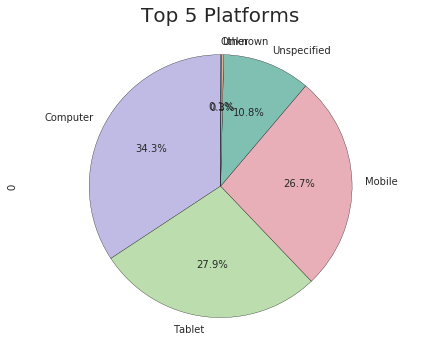

In [300]:
platforms_df = pd.DataFrame.from_dict(platforms, orient='index', dtype=int64)
pie_from_df(platforms_df, 'Top 5 Platforms', top=5)

In [217]:
# Products
products = get_column_aggregated_count(columns.index('product'))

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

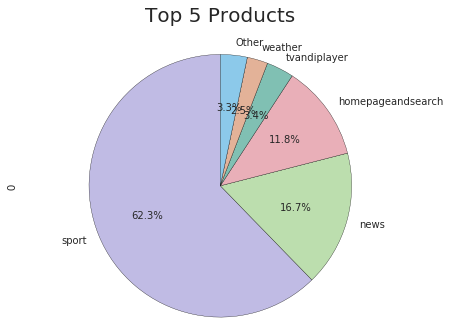

In [301]:
products_df = pd.DataFrame.from_dict(products, orient='index', dtype=int64)
pie_from_df(products_df, 'Top 5 Products', top=5)

In [219]:
# App_type
app_types = get_column_aggregated_count(columns.index('app_type'))

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

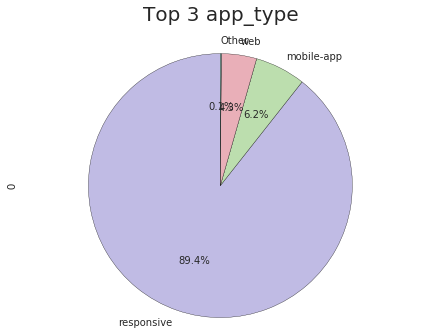

In [302]:
app_types_df = pd.DataFrame.from_dict(app_types, orient='index', dtype=int64)
pie_from_df(app_types_df, 'Top 3 app_type', top=3)

In [224]:
# Region
regions = get_column_aggregated_count(columns.index('region'))

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

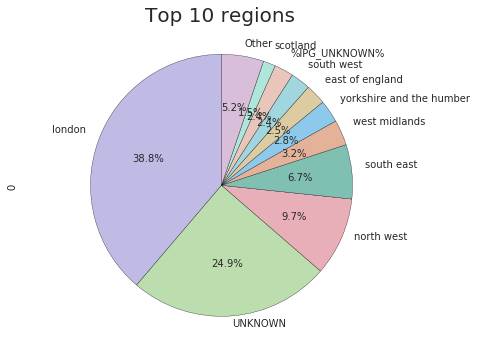

In [303]:
regions_df = pd.DataFrame.from_dict(regions, orient='index', dtype=int64)
pie_from_df(regions_df, 'Top 10 regions', top=10)

In [231]:
# Name
names = get_column_aggregated_count(columns.index('name'))

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

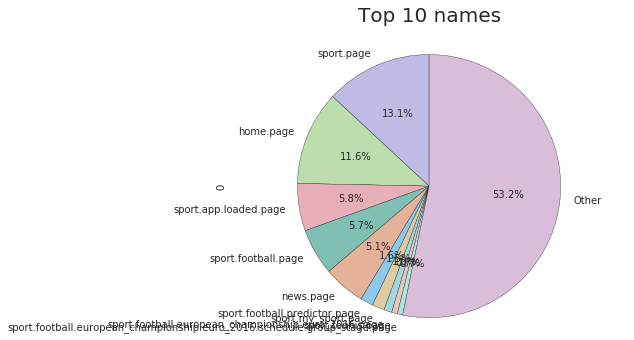

In [299]:
names_df = pd.DataFrame.from_dict(names, orient='index', dtype=int64)
pie_from_df(names_df, 'Top 10 names', top=10)

### Categorical Data initial summary
Above we can see the breakdowns of some of the categorical fields available. The charts show the top x, with the sum of all other being put under 'Other'.

Straight away we can see that in all of these cases a number of categories are dominating, and we can see there is lots of 'unknown' or junk in these fields. This will be useful when analysing in more detail. 

### Time Series
We will look at the time axis of the event data to determine aggregate trends emerging on particular days, weeks etc.

In [2]:
# Get date string and frequency for all rows
# Faster to truncate everything and then parse the date on the aggregated data
date_freq_arr_dict = get_column_aggregated_count(1, lambda date: date[:13])

# Parse aggregated date string and put into dataframe
from datetime import datetime 
date_freq_arr = []
for date, freq in date_freq_arr_dict.iteritems():
    date_freq_arr.append([datetime.strptime(date[:13], '%Y-%m-%dT%H'), freq])      
date_freq = pd.DataFrame(date_freq_arr, columns=['datetime', 'frequency']).sort_values('datetime')

# Filter outliers
date_freq = date_freq[date_freq['datetime'] <= datetime.strptime('2016-07-09','%Y-%m-%d').date()]

In [252]:
# Plot events by the hour making sure not to interpolate between values
def plot_value_by_time_bin(df, col_name, title, groups, time_bin='1H', normed=False, marker='x'):
    """
    Plot a data frame by the events per time_bin, default is hourly
    dataframe must have index of datetime
    If col_name is supplied the data is first grouped and each group will be a series
    Missing values will be added so no interpolation appears on the chart which could be misleading
    If normed=True then y values are divided by the average y value for that group
    """
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.dates as md
    import numpy as np

    plt.figure(figsize=(16, 6))
    plt.title(title)
    plt.xticks(rotation=70)
    plt.ylabel('Frequency')
    plt.grid(True, which='both')

    ax=plt.gca()

    if col_name:
        for name, group in df.groupby(col_name):
            # resample to add Nan where no data exists
            if name in groups:
                a = group.resample(time_bin).sum()
                if normed:
                    ax.plot(a.index.values, a['frequency']/np.mean(a['frequency']), label=name, linestyle='solid', marker=marker)
                else:
                    ax.plot(a.index.values, a['frequency'], label=name, linestyle='solid', marker=marker)
        ax.legend(loc='best')
    else:
        a = df.resample(time_bin).sum()
        ax.plot(a.index.values, a['frequency'], linestyle='solid', marker=marker)
    
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=None, interval=1))
    ax.xaxis.set_minor_locator(md.HourLocator(byhour=None, interval=6, tz=None))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d %H'))
    return plt

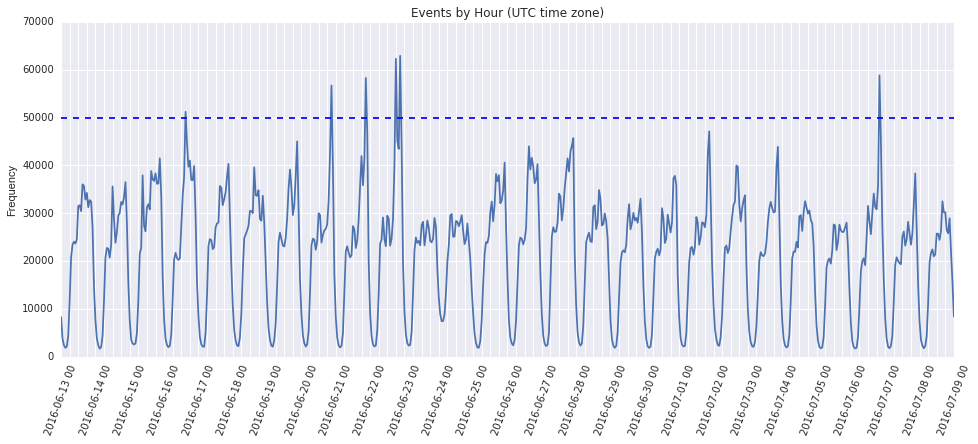

In [298]:
# Set the index as the datetime for resampling
date_freq = date_freq.set_index([pd.DatetimeIndex(date_freq['datetime'])])

# Use the plot function
plt = plot_value_by_time_bin(date_freq, None, 'Events by Hour (UTC time zone)', None, time_bin='1H')
plt.axhline(50000, linestyle='dashed')

*The above chart shows the frequency of visitor events at an hourly granularity, a dashed line has been added at frequency=50,000 to highlight the popular times*

There are clearly some sharp spikes in the above indicating a high popularity lasting in some cases just one hour. This is not a trend which occurs daily or weekly suggesting that perhaps it is driven by content (events around the world).

The dashed line has been added to differentiate the high frequency times. Those values are shown in the table below ordered by time:

In [64]:
# Display the times and dates (in UTC) which correspond to the highest popularity, i.e. those above the dashed line
date_freq_popular = date_freq[date_freq['frequency'] >= 50000]
pd.concat([date_freq_popular, date_freq_popular['datetime'].dt.strftime("%A")],axis=1)

,datetime,frequency,datetime
2016-06-16 15:00:00,2016-06-16 15:00:00,51205,Thursday
2016-06-20 21:00:00,2016-06-20 21:00:00,56708,Monday
2016-06-21 21:00:00,2016-06-21 21:00:00,58284,Tuesday
2016-06-22 18:00:00,2016-06-22 18:00:00,62287,Wednesday
2016-06-22 21:00:00,2016-06-22 21:00:00,62898,Wednesday
2016-07-06 20:00:00,2016-07-06 20:00:00,58819,Wednesday


### Time series initial summary
Four of the six most popular periods on the BBC occurred across 3 consecutive days, and 3 of these were all at 21:00 - 22:00 UTC (22:00 - 23:00 local BST). 

To determine if these events are related we will need to investigate which product and pages are being accessed at these times. 

## Detailed Exploration
Combining multiple fields together, i.e. device & time, etc to learn about more micro user patterns and help to prove / disprove the hypothesis.

At this point the data was imported into a SQL database (MySQL) for ease of access and aggregating on multiple columns. Please see `SQL/import_data.sql` for import script.

In [235]:
# An easy way to aggregate on multiple columns is using a SQL database
# See SQL/import_data.sql for import script

# Using SQL
# select 	DATE_FORMAT(dateandtime, '%Y-%m-%d %H') as Hour, 
# 		product, 
# 		count(*) as frequency
# from BBC
# group by 1, 2
# order by 1 asc;
from datetime import *

product_by_hour = pd.read_csv('data/product_by_hour_.csv', parse_dates=[0])
product_by_hour = product_by_hour.set_index([pd.DatetimeIndex(product_by_hour['Hour'])])

# Filter outliers
product_by_hour = product_by_hour[product_by_hour['Hour'] <= datetime.strptime('2016-07-09','%Y-%m-%d').date()]

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

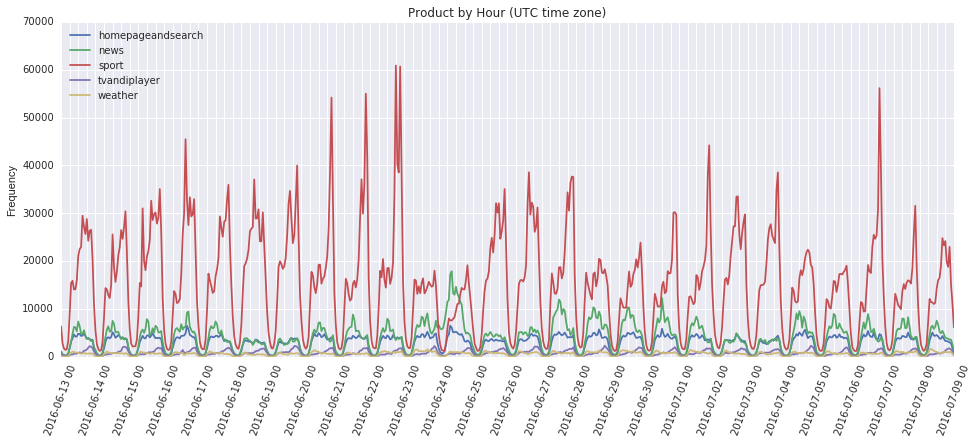

In [296]:
# Plot top products usage
plot_value_by_time_bin(product_by_hour, 'product', 'Product by Hour (UTC time zone)', 
                       top_products[:5].index, time_bin='1H')

*The above shows the usage over time of each of the 5 most popular products*

We can learn the following from the above chart:
- Sport is not only the most popular product on aggregate (62.3%) it is also the most popular at an hourly level, except from on 23-24/6/2016 when it is overtaken by news
    - This is also the maximum spike for news and it continues overnight
- The spikes we saw previously line up well with the spikes in sport, more investigation is needed to say if this is the cause exclusively
- At some times there appears to be a correllation of usages across products

It difficult to see the trend of the lesser used products, to address this we will normalise the frequency by the average frequency for the product.

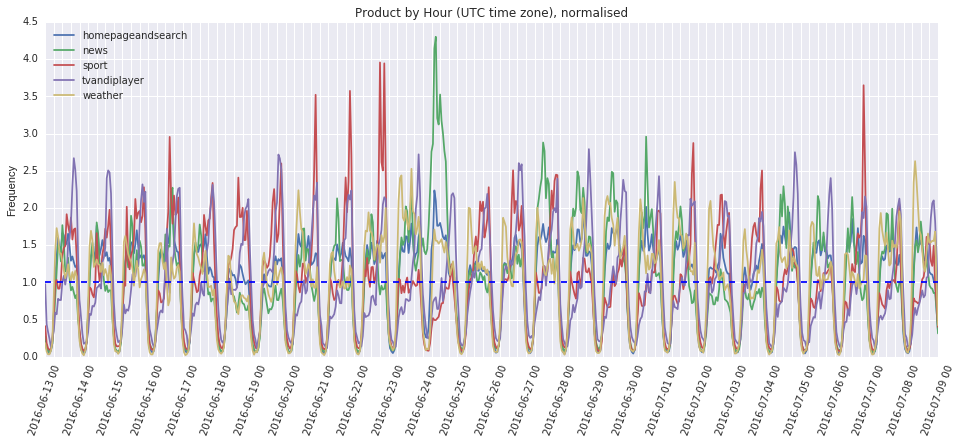

In [297]:
# Plot normalised top products usage
plt = plot_value_by_time_bin(product_by_hour, 'product', 'Product by Hour (UTC time zone), normalised', 
                       top_products[:5].index, time_bin='1H', normed=True, marker=None)
plt.axhline(1, linestyle='dashed')

*The above shows the normalised usage over time of each of the 5 most popular products, it is normalised such that the average frequency value for each group is 1 which is represented by the dotted line*

From the above we can see:
- News on 24/6/2016 was the most extreme increase in traffic for any of the channels
- Sports has regular spikes which far exceed the average traffic suggesting this is down to particular events
- tvandiplayer is most popular in the evenings and seems to follow a weekly trend, peaking on a Sunday night and declining through the week with the exception of some spikes on particular days
- It appears that homepageandsearch is correlated with news

### Correlation between products

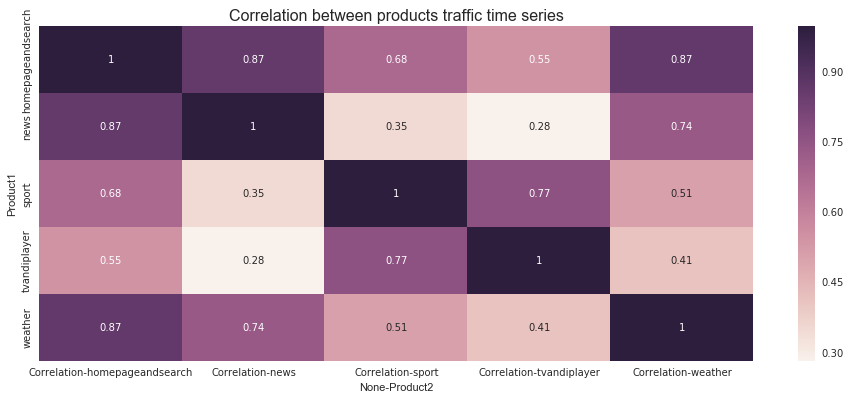

In [308]:
# Calculate the correlation of the time series 
product_by_hour_groups = product_by_hour[product_by_hour['product'].isin(top_products[:5].index)].groupby('product')

# Compare everything with everything
correlations = []
for name, group in product_by_hour_groups:
    for name2, group2 in product_by_hour_groups:
        corr = group['frequency'].corr(group2['frequency'])
        correlations.append([name, name2, corr])
correlations_df = pd.DataFrame(correlations, columns=['Product1', 'Product2', 'Correlation'])
# correlations_df
correlation_matrix = correlations_df.pivot('Product1', 'Product2')

# Plot heatmap of correlation 
def plot_heatmap(matrix, title):
    """
    Takes a matrix and plots a heatmap
    """
    import seaborn as sns
    plt.figure(figsize=(16, 6))
    ax=plt.gca()
    ax.set_title(title, fontsize=16)
    sns.heatmap(matrix, annot=True, fmt=".2g", ax=ax);
    
plot_heatmap(correlation_matrix, "Correlation between products traffic time series")

*The above shows the pearson correlation of the time series for each of the products*

We can see from the correlation matrix above that indeed `news` and `homepageandsearch` have a very high correlation. This is not surprising since there are many links on the homepage which lead to the news.
- 'homepageandsearch' correlates well with news, weather and sport
    - This is not surprising since there are links on the homepage to take you to these destinations
    - Further it is likely a search would take you to one of these too
- News correlates strongly with weather
- Sport correlates strongly with tvandiplayer
    - Perhaps some of the sports are watched there

In [241]:
# Using below SQL to generate data/platform_by_hour_.csv
#
# select 	DATE_FORMAT(dateandtime, '%Y-%m-%d %H') as Hour, 
# 		platform, 
# 		count(*) as frequency
# from BBC
# group by 1, 2
# order by 1 asc;
platform_by_hour = pd.read_csv('data/platform_by_hour_.csv', parse_dates=[0])
platform_by_hour = platform_by_hour.set_index([pd.DatetimeIndex(platform_by_hour['Hour'])])

# Filter outliers
platform_by_hour = platform_by_hour[platform_by_hour['Hour'] <= datetime.strptime('2016-07-09','%Y-%m-%d').date()]

# List values
top_platforms = platform_by_hour.groupby('platform').sum().sort_values('frequency', ascending=False, na_position='last')

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

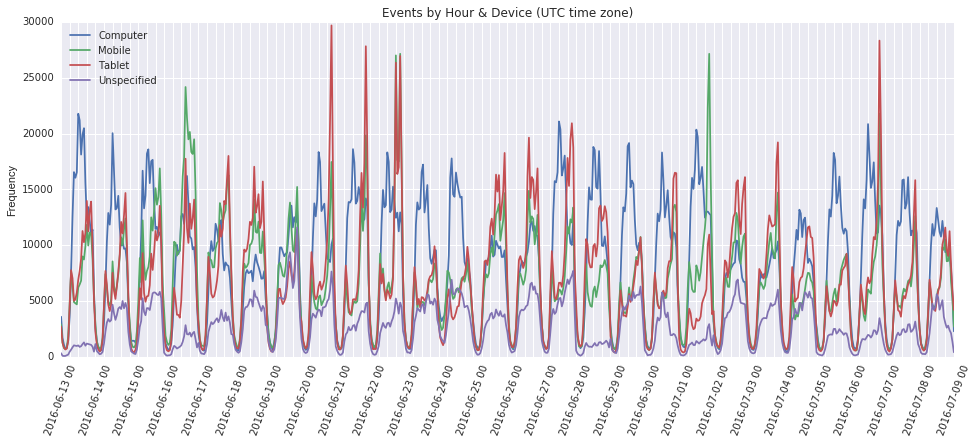

In [295]:
# Plot the top 4 platforms as time series
plot_value_by_time_bin(platform_by_hour, 'platform', 'Events by Hour & Device (UTC time zone)', 
                       top_platforms[:4].index, normed=True)

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

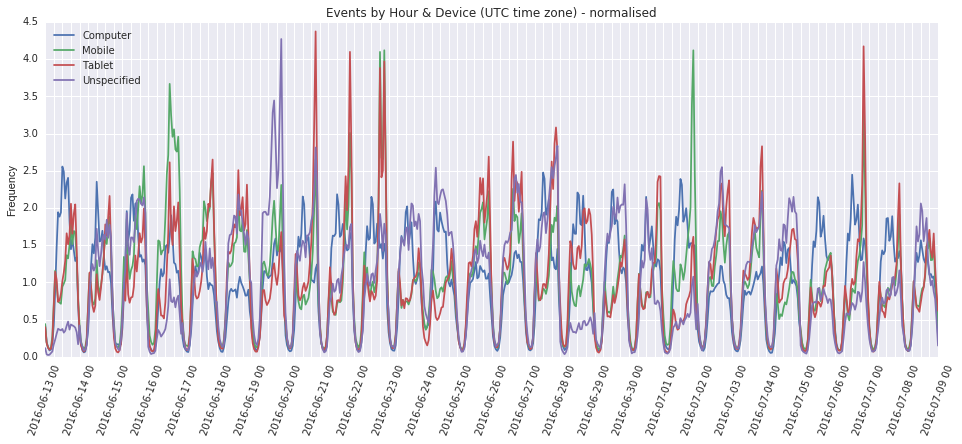

In [434]:
plot_value_by_time_bin(platform_by_hour, 'platform', 'Events by Hour & Device (UTC time zone) - normalised', 
                       top_platforms[:4].index, normed=True)

*The above two charts show the breakdown of device usage over time for the top 4 devices*

## Are visitors only interested in big events ? 

With the aid of the initial analysis we can begin to answer this question.

To do this we need to know the following:
- What were the big events we can see in the above charts ? 
- Do the visitors accessing these events come back / have we seen them before ? 

### What were the big events we can see in the above charts ?

We know from the above the most popular periods, which products were being accessed and on which devices.

In [315]:
# Zooming in on our popular news and sports events
product_groups = product_by_hour.groupby(by='product')
pop_sports_events = product_groups.get_group('sport').sort_values(by='frequency', ascending=False)[:5]
pop_news_events = product_groups.get_group('news').sort_values(by='frequency', ascending=False)[:2]
pop_sports_events.append(pop_news_events).sort_index()

,Hour,product,frequency
2016-06-20 21:00:00,2016-06-20 21:00:00,sport,54185
2016-06-21 21:00:00,2016-06-21 21:00:00,sport,54993
2016-06-22 18:00:00,2016-06-22 18:00:00,sport,60877
2016-06-22 21:00:00,2016-06-22 21:00:00,sport,60686
2016-06-24 08:00:00,2016-06-24 08:00:00,news,17194
2016-06-24 09:00:00,2016-06-24 09:00:00,news,17854
2016-07-06 20:00:00,2016-07-06 20:00:00,sport,56154


We can find out the most popular items at those times. See the script in `SQL/pick_out_top_pages.sql`.

In [345]:
top_pages = pd.read_csv('data/top_pages.csv').groupby(by=['Hour','product','name']).sum()
g = top_pages.groupby(level=0, group_keys=False)
g.apply(lambda x: x.sort_values(by='count(*)', ascending=False).head(3))

count(*)
Hour          product name                                                        
2016-06-20 21 sport   sport.page                                              9669
                      sport.football.european_championship.2016.live_...      9185
                      sport.app.loaded.page                                   4835
2016-06-21 21 sport   sport.page                                              9534
                      sport.football.european_championship.2016.live_...      6566
                      sport.cricket.live_coverage.36211629.page               5413
2016-06-22 18 sport   sport.football.european_championship.2016.live_...     13526
                      sport.page                                              9530
                      sport.app.loaded.page                                   5155
2016-06-22 21 sport   sport.football.european_championship.2016.live_...     11111
                      sport.page                                              9543
                      sport.app.loaded.page                                   5039
2016-06-24 08 news    news.page                                               4255
                      news.politics.eu_referendum.live_coverage.36570...      1750
                      news.politics.eu_referendum.story.36615028.page         1579
2016-06-24 09 news    news.page                                               4249
                      news.politics.eu_referendum.live_coverage.36570...      1609
                      news.politics.eu_referendum.story.36615028.page         1010
2016-07-06 20 sport   sport.page                                             12536
                      sport.tennis.live_coverage.36385047.page               12527
                      sport.football.european_championship.2016.live_...      6399

The table above shows the top 3 `name` pages for each of the most popular periods in order of their popularity.

We can see that these are down to key events in football and politics, including the eu referendum. 

There is also a rise in visits to the generic pages in news and sport at these times suggesting users first go to these landing pages before getting to the content they want to consume.

The key question is: 
> how many of the visitors to the particular content pages return on other days ? 

The football events are numerous in the data set and so I will focus on the eu referendum events to answer this question.
- news.politics.eu_referendum.live_coverage.36570120.page

In [436]:
# SQL used
# 
# select number_of_visiting_days, count(*) as num_users
# from (
# 	select count(distinct date(b2.dateandtime)) as number_of_visiting_days
# 	from BBC b1,
# 	BBC b2
# 	where b1.name = 'news.politics.eu_referendum.live_coverage.36570120.page'
# 	and b2.userid = b1.userid
# 	group by b1.userid
# ) x
# group by number_of_visiting_days
# order by 1 asc
# ;
n_of_visiting_days = pd.read_csv('data/number_of_visiting_days_for_eu_ref_users.csv')

print 'total unique users = ' + str(n_of_visiting_days['num_users'].sum())

total unique users = 24224


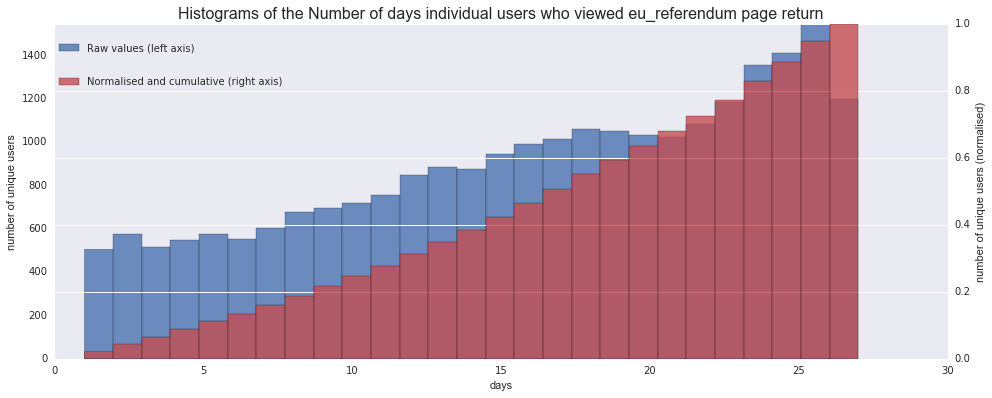

In [443]:
# Plot histogram
plt.figure(figsize=(16, 6))
plt.title('Histograms of the Number of days individual users who viewed eu_referendum page return', fontsize=16)
ax1 = plt.gca()
ax1.set_xlabel('days')
ax1.set_ylabel('number of unique users')
ax1.set_ylim([0,max(n_of_visiting_days['num_users'])])
ax1.set_xlim([0,28])

# plot regular histogram
p1 = ax1.hist(n_of_visiting_days['number_of_visiting_days'], len(n_of_visiting_days),
         weights=n_of_visiting_days['num_users'], cumulative=False, normed=False, label='Raw values (left axis)',alpha=.8);

# plot normalised & cumulative histogram
ax2 = ax1.twinx()
ax2.set_ylim([0,1])
ax2.set_ylabel('number of unique users (normalised)')
n, bins, patches = ax2.hist(n_of_visiting_days['number_of_visiting_days'], len(n_of_visiting_days),
         weights=n_of_visiting_days['num_users'], cumulative=True, normed=1, label='Normalised and cumulative (right axis)', 
              color=sns.color_palette()[2], alpha=.8);
ax1.legend(loc=(0,0.9))
ax2.legend(loc=(0,0.8))
ax1.grid(False)

plt.show()

In [444]:
# Value at 1 day (zero based)
print 'Value at 1 day = ' + str(n[0] * 100) + '%'

Value at 1 day = 2.08470937913%


In [441]:
# Value at 10 day (zero based)
print 'Value at 10 day = ' + str((1-n[9]) * 100) + '%'

Value at 10 day = 75.3674042272%


24,224 Unique users (by userid) accessed the `news.politics.eu_referendum.live_coverage.36570120.page`

Of those users only __2% did not return__ on another day in the data set, and __75.4% of people went on to visit the site on 10 or more seperate dates__. On average a user who accessed that news artical returned to the site on 17 seperate dates in the period. 

This data suggests extremely regular use for this cross section of users.

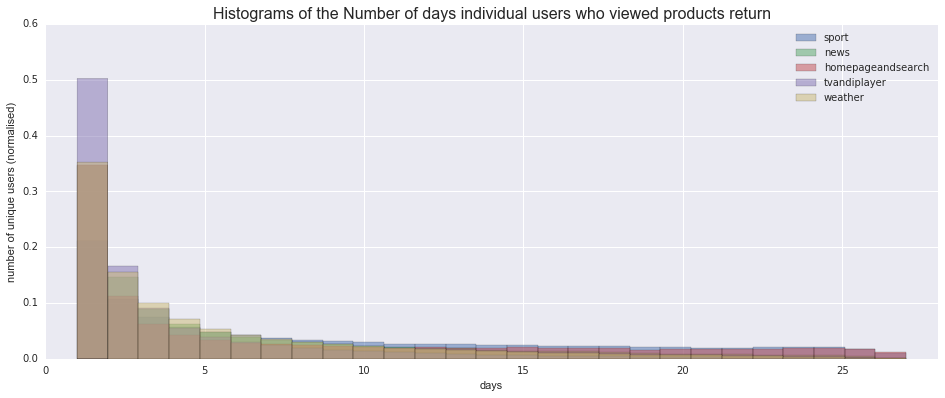

In [520]:
# Unqiue dates visited for the top products
# SQL used
# 
# select product, number_of_visiting_days, count(*)
# from
# (
#     select product, count(distinct date(dateandtime)) as number_of_visiting_days
#     from BBC b1
#     group by product, userid
# ) x
# group by 1,2
# order by 1,2;

n_of_visiting_days_product = pd.read_csv('data/number_of_visiting_days_for_product.csv')
# limit to top 5
n_of_visiting_days_product = n_of_visiting_days_product[n_of_visiting_days_product['product'].isin(top_products[:5].index)]

# Plot histograms
def plot_histograms(df, categories_column, categories):
    """
    Plot histograms for each of the categories
    assumes data is of the form category, number_of_visiting_days, count(*)
    """
    plt.figure(figsize=(16, 6))
    plt.title('Histograms of the Number of days individual users who viewed products return', fontsize=16)
    ax1 = plt.gca()
    ax1.set_xlabel('days')
    ax1.set_ylabel('number of unique users (normalised)')
    ax1.set_xlim([0,28])
    
    # plot regular histogram
    for cat in categories:
        _df = df[df[categories_column]==cat]
        ax1.hist(_df['number_of_visiting_days'], len(_df),
                 weights=_df['count(*)'], cumulative=False, normed=True, label=cat, alpha=.5);

    ax1.legend(loc='best')
    plt.show()
    
plot_histograms(n_of_visiting_days_product, 'product', top_products[:5].index)

Strangely it seems that this strong revisting is not repeated at a product level.

On aggregate we can see from the above an exponential drop off in users from day 1 across all of the products. This is either telling us that in many cases a user only visits once, or we are not able to track them well in future sessions, perhaps they have changed device or cleared cookies.

This is most extreme for tvandiplayer where 50% of users only visited on one day in the data set

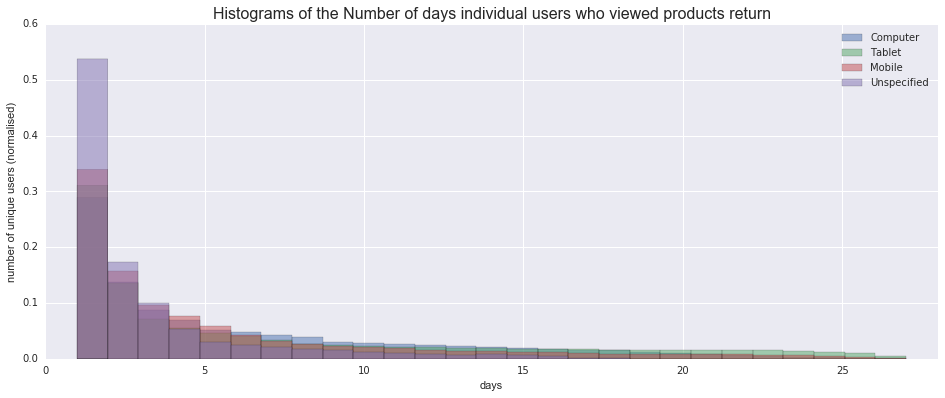

In [521]:
# Unqiue dates visited for the top platforms
# SQL used
# 
# select platform, number_of_visiting_days, count(*)
# from
# (
#     select platform, count(distinct date(dateandtime)) as number_of_visiting_days
#     from BBC b1
#     group by platform, userid
# ) x
# group by 1,2
# order by 1,2;

n_of_visiting_days_platform = pd.read_csv('data/number_of_visiting_days_for_platform.csv')
# limit to top 5
n_of_visiting_days_platform = n_of_visiting_days_platform[n_of_visiting_days_platform['platform'].isin(top_platforms[:4].index)]

# Plot histograms   
plot_histograms(n_of_visiting_days_platform, 'platform', top_platforms[:4].index)

Again at device level we see a strong negative exponential trend in the number of unique days a user comes back on that same device.

It seems very odd that such a strong trend exists for users aggregated across product or devices but almost the opposite trend is seen for user who viewed the referendum article.

I suspect that this trend is due to the way in which the data has been sampled. Randomly selecting rows would lead to an exponentially decreasing propability of choosing the same user in the next selection. 

#### User Device overlap

>Do users access the BBC on multiple devices ? 

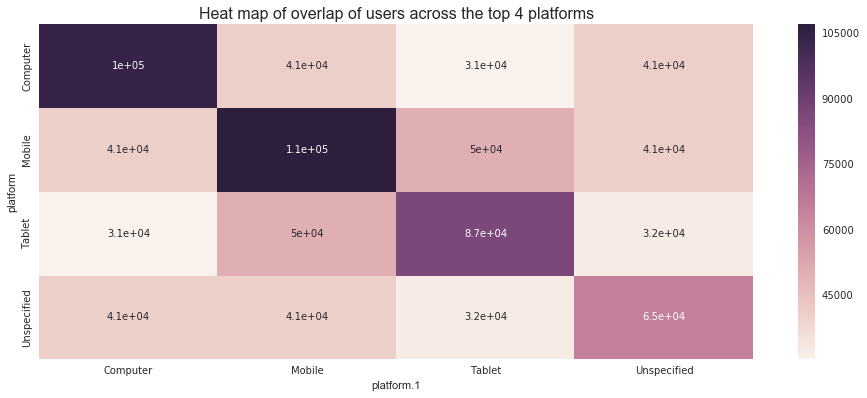

In [489]:
# Using SQL in file platform_platform_overlap.sql
platform_overlap = pd.read_csv('data/platform_platform_overlap.csv')
top_platform_overlap = platform_overlap[platform_overlap['platform'].isin(top_platforms[:4].index) & 
                platform_overlap['platform.1'].isin(top_platforms[:4].index)]

# Plot heatmap of overlap 
import seaborn as sns
plt.figure(figsize=(16, 6))
ax=plt.gca()
ax.set_title('Heat map of overlap of users across the top 4 platforms', fontsize=16)
# Pivot dataframe of platform1, platform2, count into square matrix
platform_overlap_matrix = top_platform_overlap.pivot("platform", "platform.1", "count(*)")
sns.heatmap(platform_overlap_matrix, annot=True, fmt=".2g", ax=ax);

*The chart above shows the number of users which overlap devices, it is symmetric*

The popular devices by distinct users are Mobile, Computer and Tablet unsuprisingly. If we normalise these values based on the unique users we get a better idea of the relative overlap.

In [477]:
def normalise_matrix(df):
    """
    Normalise elements by dividing by the diagonal on that row
    Turns each element into a % of the diagonal of that row
    """
    new = {}
    names = []
    for name, row in df.iterrows():
        vals = []
        for el in row:
            try:
                vals.append(float(el)/df[name][name])
            except:
                vals.append(-1)
        names.append(name)
        new[name] = vals

    norm = pd.DataFrame(new).T
    norm.columns = names
    return norm

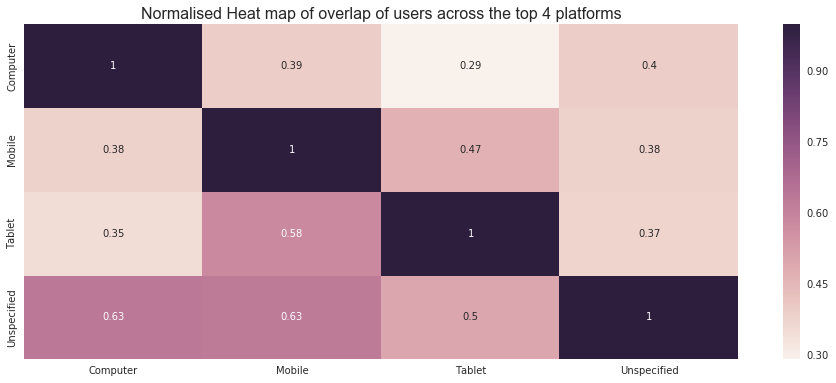

In [488]:
plt.figure(figsize=(16, 6))
ax=plt.gca()
ax.set_title('Normalised Heat map of overlap of users across the top 4 platforms', fontsize=16)
sns.heatmap(normalise_matrix(platform_overlap_matrix), annot=True, fmt=".2g", ax=ax);

*The chart above shows the normalised number of users which overlap devices, it is normalised such than each row element is divided by the diagonal of that row*

With the normalised results we can see some clear strong overlaps.

There is a huge cross over of mobile - tablet users, with more than 47% of tablet users accessing the bbc on mobile. The cross over between Computer and Mobile is relatively small (39% of computer users) considering that most PC owners will have access to a mobile phone.

Assuming there are no tracking issues of users going between PC and mobile I would suggest a campaign to get PC users consuming on mobile, this could be driven by email to enable the campaign to work cross-device.

#### Product Overlap

>Do users access multiple products from the BBC ? 

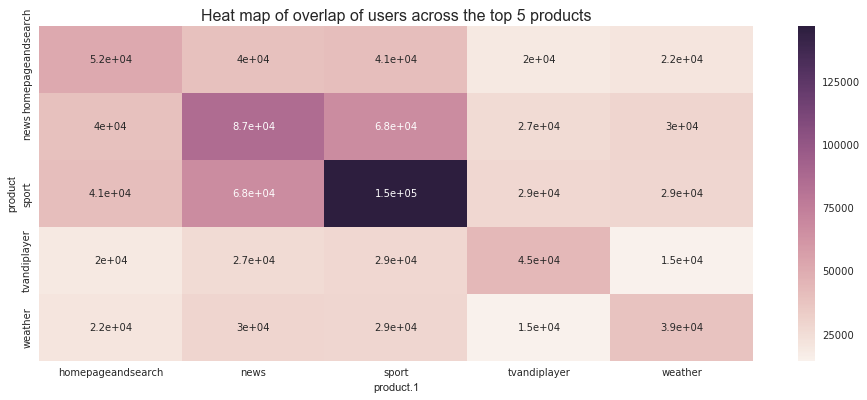

In [485]:
# Using SQL in file product_product_overlap.sql
product_overlap = pd.read_csv('data/product_overlap.csv')
top_product_overlap = product_overlap[product_overlap['product'].isin(top_products[:5].index) & 
                product_overlap['product.1'].isin(top_products[:5].index)]

import seaborn as sns
plt.figure(figsize=(16, 6))
ax=plt.gca()
ax.set_title('Heat map of overlap of users across the top 5 products', fontsize=16)
top_product_overlap_matrix = top_product_overlap.pivot("product", "product.1", "count(*)")
sns.heatmap(top_product_overlap_matrix, annot=True, fmt=".2g", ax=ax);

*The chart above shows the number of users which overlap products, it is symmetric*

The popular devices by distinct users are Sport, News, and homepageandsearch. 

The best overlap is sport and news. To get an idea of the relative sizes of the overlaps we will now normalise this matrix. 

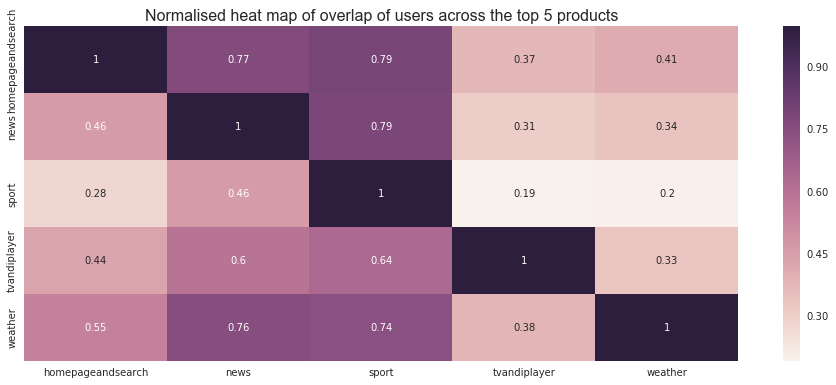

In [487]:
import seaborn as sns
plt.figure(figsize=(16, 6))
ax=plt.gca()
ax.set_title('Normalised heat map of overlap of users across the top 5 products', fontsize=16)
sns.heatmap(normalise_matrix(top_product_overlap_matrix), annot=True, fmt=".2g", ax=ax);

*The chart above shows the normalised number of users which overlap devices, it is normalised such than each row element is divided by the diagonal of that row*

We can now see the % size of each overlap when compared with the number of unique users for each product. For example the overlap sport > news is 0.46 meaning 46% of sport users also use the news, this is not symmetric and so we can see that 79% of news users also use sports.

## Summary

> the majority of visitors to the BBC are only interested in big events

Clearly popular events such as the eu referendum and eu football have a large impact on the traffic to the BBC for products such as sport, news and homepageandsearch. However it is evident that for some of these users do return to the site on a regular basis. For example on average of the users who viewed the most popular article on the referedum on average returned on 17 different dates across the period. However this is not the case in general and the is a strong trend for users to only visit a product or from a device on one day in the dataset - this could

If we assume that 'big events' occur only infrequently I would conclude that this is not the case since it is clear that a large section of the user base return frequently to the various products.

> recommendations on how to increase the reach, depth and breadth of usage of the BBC’s portfolio

- Reach

I assume this means the total number of unique users by which the BBC portfolio is accessed.

Clearly big events are popular across the portfolio, we know this to be true. 

Based on this knowledge I would suggest that advertising these big events would be a good driver for getting new users in. 

For example when the eu referendum was taking place an advertised tweet on twitter could direct huge numbers of people to the site as their chosen news source.

- Depth

I assume that this means the amount of content consumed within a single product by users.

We can see from the histograms plotted above that in general users do not revist the site on multiple days within the data set. 

This could in part be due to the sampling that might have taken place to make this data set. One would expect if rows were selected at random then this exponential decrease of users over days would be evident as the probably for resampling the same user over and over again decreases exponentially.

However if this really is the case then I would suggest that retargeting these users could be a highly effective means of advertising. 

There is an enormous audience who are only visiting the site once. If they were to be cookied and retargeted with ads across the web they would be likely to come back. In particular we would be able to generate specific recommendations of content based on their previous history. A banner ad for a football fan of news about their favourite team for example could be very powerful advertising.

- Breadth

I assume that this means the number of different products and different device formats consumed by users.

We have shown here that a number of the products offered by the BBC have a strong overlap. I would therefore recommend pushing the products which are known to overlap well with sport as a means of getting users moving around other products and similarly for devices.

For example if a big sport event is  attracting users for the sport section then this audience is likely to be succeptable to being targeted for news - we can infer this because sport and news already have a high cross over as shown earlier. 

In particular this retargeting of sports users to other products can be particularly effective because it is the product with by far the largest audience currently. This targeting could be done onsite by making sure there are clear and visible links to the related products.

# User Segmentation

I ran out of time to work on this aspect. My initial thoughts were to create a new data set with the following:
- number of unique days visited (total)
- number of unique days visited (one column per each device)
- number of unique days visited (one column per each product)
- number of times visited at time of day (one column per morning, lunch, afternoon, evening)

I would then be looking at running some unsupervised clustering models over this data to find some collections within this, for example DBSCAN.